In [ ]:
""" 
File to import and implement ARIMA models and different types of smoothing and lagging
"""

In [1]:
# Imports 
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
# import Sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Load data
df_prod = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-CONS.csv")
df_cons = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-PROD.csv")

df_prod_2_year_cons = pd.read_csv('data/year_coverage_consumption_100.csv')
df_prod_2_year_prod = pd.read_csv('data/year_coverage_production_100.csv')

df_prod_2_year_prod = df_prod_2_year_prod[df_prod_2_year_prod["time_between_first_last"] >= 2]
df_prod_2_year_cons = df_prod_2_year_cons[df_prod_2_year_cons["time_between_first_last"] >= 2]

# Sort by time_between_first_last
df_prod_2_year_cons = df_prod_2_year_cons.sort_values(by=['time_between_first_last'], ascending=False)
df_prod_2_year_prod = df_prod_2_year_prod.sort_values(by=['time_between_first_last'], ascending=False)

In [3]:
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_cons["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

In [52]:
# Define a baseline function
def baseline_model(series, units_to_forecast, unit = "hours"):
    """Create baseline from series

    Args:
        series (pd.Series): series to create baseline from
        days_to_forecast (int): days to forecast

    Returns:
        pd.Series: Baseline forecast
    """

    if unit == "days":
        factor = 1
    if unit == "hours":
        factor = 24

    # For each day to forecast, get the value from the last week
    # Create series with index same as series
    baseline = pd.Series(index=series.index[-units_to_forecast+1:])
    print(baseline)
    # For each day to forecast
    for i in range(units_to_forecast-1):
        # Get the last week
        last_week = series.iloc[i-7*2*factor]
        # Add to baseline
        baseline[i] = last_week

    
    # Return forecast
    # invert the list
    return baseline

In [5]:
# Cut data to only use the first year
series = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3",
                        type="prod",
                        start=None,
                        end=None,
                        agg="day")
print(series.head(10))

Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
                           num_kwh_normalized
timeslot                                     
2016-09-03 00:00:00+00:00            0.027778
2016-09-04 00:00:00+00:00            0.694444
2016-09-05 00:00:00+00:00            0.555556
2016-09-06 00:00:00+00:00            1.250000
2016-09-07 00:00:00+00:00            0.944444
2016-09-08 00:00:00+00:00            0.694444
2016-09-09 00:00:00+00:00            1.138889
2016-09-10 00:00:00+00:00            1.638889
2016-09-11 00:00:00+00:00            1.166667
2016-09-12 00:00:00+00:00            0.750000


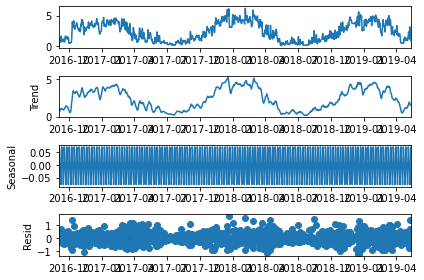

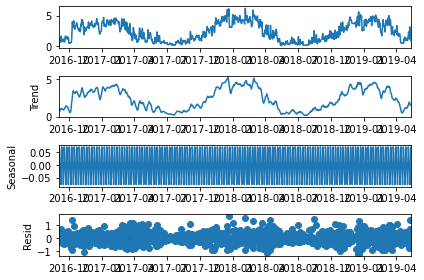

In [7]:
# Fit Seasonal Decomposition
decomp = seasonal_decompose(series, model="additive")
decomp.plot()

In [ ]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# Running the ADF Test shows that the p-value is larger than 0.05 and we can therefore not reject the null hypothesis that the series is non stationary.
print(adf_test(series))
print()

# We therefore difference the series to make it stationary and then run the ADF test again.
series_diff = series.diff(1).dropna()
print(adf_test(series_diff))
# The p-value is now smaller than 0.05 and we can therefore reject the null hypothesis that the series is non stationary.

In [ ]:
# We can also just cheat and use pmdarima to get the best difference term
from pmdarima.arima import ndiffs, nsdiffs 

print(ndiffs(series))
print(nsdiffs(series, m=4*30))

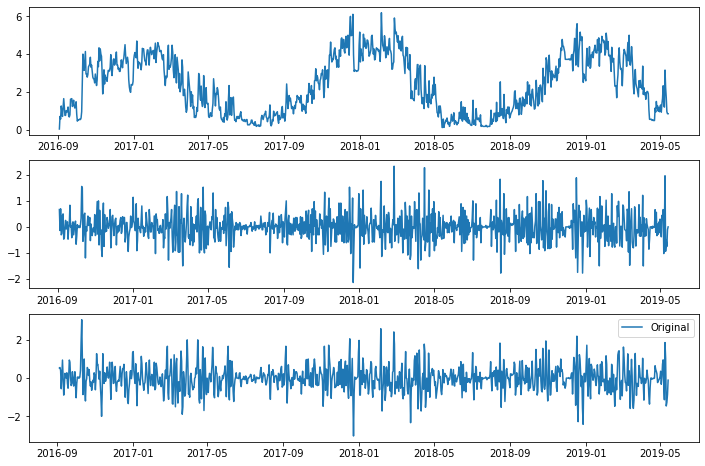

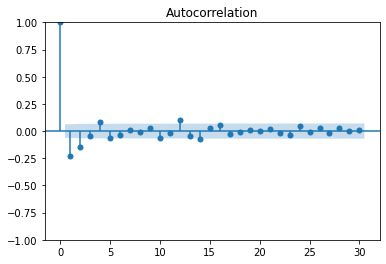

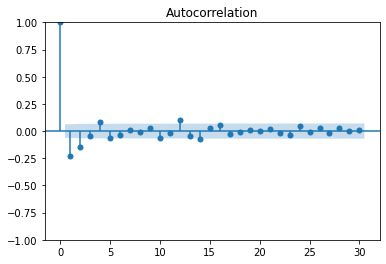

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import make_subplots

series_1_diff = series.diff().dropna()
series_2_diff = series.diff(2).dropna()

# make matplotlib subplots for plotting series_1_diff and series_2_diff
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
ax1.plot(series)
ax2.plot(series_1_diff)
ax3.plot(series_2_diff)
plt.legend(['Original', '1st Diff', '2nd Diff'])

plt.show()

plot_acf(series_1_diff)

We see that the series is stationary when doing a single difference

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.45563D-01    |proj g|=  6.12942D-02


 This problem is unconstrained.



At iterate    5    f=  7.43089D-01    |proj g|=  5.46738D-03

At iterate   10    f=  7.42632D-01    |proj g|=  7.72464D-05

At iterate   15    f=  7.42631D-01    |proj g|=  8.17775D-04

At iterate   20    f=  7.42532D-01    |proj g|=  9.09041D-03

At iterate   25    f=  7.42348D-01    |proj g|=  3.50128D-03

At iterate   30    f=  7.42265D-01    |proj g|=  4.95464D-04

At iterate   35    f=  7.42235D-01    |proj g|=  2.17713D-04

At iterate   40    f=  7.42225D-01    |proj g|=  2.93268D-04

At iterate   45    f=  7.42221D-01    |proj g|=  8.23380D-04


/Users/augusttollerup/Documents/SEM4/Fagprojekt/Otovo-OptimalControl/otovo/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.42219D-01    |proj g|=  5.69366D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   5.694D-04   7.422D-01
  F =  0.74221930530247715     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
timeslot
2019-05-12 00:00:00+00:00   NaN
2019-05-13 00:00:00+00:00   NaN
2019-05-14 00:00:00+00:00   NaN
Freq: D, dtype: float64


/var/folders/b1/gpnk8rp50gd31snzzh0dyycr0000gn/T/ipykernel_74301/1917191787.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  baseline = pd.Series(index=series.index[-units_to_forecast+1:])


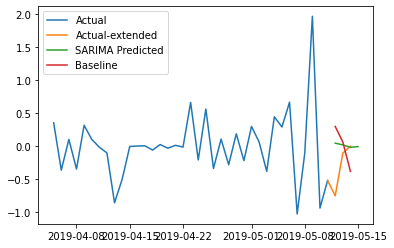

In [79]:
# Fit model

# ARIMA MODEL EXPLAINED
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

train_series = series_1_diff

units_to_forecast = 4

AR = 1
I = 0
MA = 1

# SARIMA
ARIMA_order = (AR, I, MA)
SEASONAL_order = (1, 0, 1, 4*30)

sarima_model = SARIMAX(train_series[:-units_to_forecast+1], order=ARIMA_order, seasonal_order=SEASONAL_order)
sarima_model_fit = sarima_model.fit()
sarima_forecast = sarima_model_fit.forecast(steps=units_to_forecast)

# ACTUAL
actual = train_series[-units_to_forecast*10:-units_to_forecast+1]
actual2 = train_series[-units_to_forecast:]

# BASELINE
baseline_forecast = baseline_model(train_series, units_to_forecast, unit = "days")

# Add the last value of the actual series to the first value of the forecast and baseline
# sarima_forecast = pd.concat([actual.iloc[-1], sarima_forecast])

# plot the error between the actual and predicted values
plt.plot(actual, label="Actual")
plt.plot(actual2, label="Actual-extended")
plt.plot(sarima_forecast, label="SARIMA Predicted")
plt.plot(baseline_forecast, label="Baseline")
plt.legend()
plt.show()